In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nsepy import get_history
%matplotlib inline
from datetime import date, timedelta, datetime

In [22]:
# Initialising the number of years of training data to be downloaded from NSE
training_no_of_years = 12
# Initialising start and end dates for stock data download
start_date = date.today() - timedelta(days = 365*training_no_of_years + training_no_of_years//4) #adjusting no of days for leap years in between
end_date = date.today()

In [23]:
# Stock selected is State Bank of India (NSE: SBIN), the largest bank in India and one of the most liquid stocks
stockdf = get_history(symbol = 'SBIN', start = start_date, end = end_date)

In [24]:
stockdf = stockdf.drop(['Trades', 'Turnover'], axis=1)

In [25]:
stockdf.head(3)

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,
2009-11-10,SBIN,EQ,2318.20,2338.0,2381.90,2325.0,2365.1,2368.90,2357.25,4183301,1561318,0.3732
2009-11-11,SBIN,EQ,2368.90,2365.0,2384.50,2330.0,2378.0,2378.25,2357.21,2242076,512165,0.2284
2009-11-12,SBIN,EQ,2378.25,2370.0,2378.25,2276.0,2300.0,2293.65,2323.20,2225929,547072,0.2458


In [26]:
stockdf.describe() # result shows that the stock data is not adjusted for a 1:10 split


,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Deliverable Volume,%Deliverble
count,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2.980000e+03,2.980000e+03,2980.000000
mean,1099.293624,1100.004681,1114.216074,1084.587164,1098.475134,1098.697701,1099.639470,1.745760e+07,4.934078e+06,0.312659
std,994.368783,995.164620,1007.666170,981.826959,993.850234,994.188069,994.962097,2.243758e+07,6.000287e+06,0.102485
min,150.850000,151.950000,153.200000,148.250000,151.100000,150.850000,151.820000,8.841100e+04,1.799700e+04,0.083700
25%,268.537500,268.900000,272.000000,265.637500,268.787500,268.537500,268.857500,2.139100e+06,6.758570e+05,0.236000
50%,338.175000,338.450000,344.175000,333.450000,338.400000,338.175000,338.900000,1.143174e+07,3.495674e+06,0.303700
75%,2119.625000,2124.962500,2150.875000,2095.012500,2117.450000,2117.950000,2125.600000,2.259668e+07,7.097378e+06,0.381325
max,3489.950000,3505.000000,3515.000000,3451.350000,3499.000000,3489.950000,3485.250000,2.626771e+08,1.333311e+08,0.716200


In [27]:
#Adjusting stock closing prices for splits of 1:10
stockdf['Close'] = stockdf['Close'].apply(lambda x:x/10 if x>1000 else x)

In [28]:
# Forming a 2-d array of closing prices to be fed into RNN
# We take the last 20 day prices in the test data (corresponding roughly to 1 calendar month)
trend_test_days = 20
training_set = stockdf.iloc[:len(stockdf)-trend_test_days,7:8].values


In [29]:
training_set, len(training_set)


(array([[236.89 ],
        [237.825],
        [229.365],
        ...,
        [457.2  ],
        [457.9  ],
        [458.   ]]),
 2960)

In [30]:
# Using normalisation to scale data, as RNN uses distance between data points to train 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
training_set_scaled = scaler.fit_transform(training_set)

In [31]:
# The recurrent neural network with long short term memory (LSTM) will use a timestep of 120 trading days as memory
# Creating the data structure which preserves 120 days of memory
X_train = [] #initiate training lists
y_train = []
memory_range = 120
for i in range(memory_range, len(training_set_scaled)):
    X_train.append(training_set_scaled[(i - memory_range):i,0])
    y_train.append(training_set_scaled[i,0])

#Convert the lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [32]:
X_train.shape, y_train.shape

((2840, 120), (2840,))

In [33]:
# reshape the x_train array to fit the shape expected by RNN algorithm
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2840, 120, 1)

In [34]:
# Importing the RNN libraries and classes
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [35]:
#Initialise the regressor object of class Sequential
regressor = Sequential()

In [36]:
#Building the RNN architecture with dropout regularisation
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, activation = 'tanh', return_sequences = False)) # last LSTM layer should have return sequence as False
regressor.add(Dropout(0.2))
#Adding the output layer
regressor.add(Dense(units = 1))

In [37]:
#Compile the recurrent neural network
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [38]:
#Fitting the RNN model on training data
regressor.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
89/89 [==============================] - 17s 138ms/step - loss: 0.0130
Epoch 2/100
89/89 [==============================] - 10s 111ms/step - loss: 0.0049
Epoch 3/100
89/89 [==============================] - 10s 109ms/step - loss: 0.0043
Epoch 4/100
89/89 [==============================] - 10s 108ms/step - loss: 0.0035
Epoch 5/100
89/89 [==============================] - 10s 113ms/step - loss: 0.0034
Epoch 6/100
89/89 [==============================] - 10s 107ms/step - loss: 0.0030
Epoch 7/100
89/89 [==============================] - 10s 107ms/step - loss: 0.0027
Epoch 8/100
89/89 [==============================] - 9s 105ms/step - loss: 0.0027
Epoch 9/100
89/89 [==============================] - 10s 107ms/step - loss: 0.0024
Epoch 10/100
89/89 [==============================] - 10s 111ms/step - loss: 0.0021
Epoch 11/100
89/89 [==============================] - 10s 109ms/step - loss: 0.0023
Epoch 12/100
89/89 [==============================] - 11s 120ms/step - loss: 0.0021
Ep

89/89 [==============================] - 8s 88ms/step - loss: 7.3337e-04
Epoch 98/100
89/89 [==============================] - 8s 89ms/step - loss: 7.4403e-04
Epoch 99/100
89/89 [==============================] - 8s 89ms/step - loss: 8.4067e-04
Epoch 100/100
89/89 [==============================] - 8s 89ms/step - loss: 6.7824e-04


In [39]:
test_set = stockdf.iloc[len(stockdf) - memory_range - trend_test_days:,7:8].values
test_set = scaler.transform(test_set)
test_set.shape

(140, 1)

In [40]:
# preparing the test input data structure
X_test = []
for i in range(memory_range, memory_range + trend_test_days):
    X_test.append(test_set[i - memory_range:i, 0])
X_test = np.array(X_test)

In [41]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(20, 120, 1)

In [42]:
# Predict stock prices for the last 20 days
predicted_stock_prices = regressor.predict(X_test)
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

In [43]:
# Get actual stock prices for comparison of trend prediction
actual_stock_prices = stockdf.iloc[len(stockdf) - trend_test_days:,7:8].values
actual_stock_prices.shape, predicted_stock_prices.shape

((20, 1), (20, 1))

In [44]:
# Get data in dataframe format with added accuracy measures
final_stock_pred = pd.DataFrame(data = actual_stock_prices, columns = ['actual_stock_prices'])
final_stock_pred = pd.concat((final_stock_pred, pd.DataFrame(data = predicted_stock_prices, columns = ['predicted_stock_prices'])), axis=1)

In [45]:
final_stock_pred['actual_change'] = np.zeros(len(final_stock_pred))
final_stock_pred['predicted_change'] = np.zeros(len(final_stock_pred)) 

for i in range(0,len(final_stock_pred)-1):
    final_stock_pred['actual_change'][i+1] = ((final_stock_pred['actual_stock_prices'][i+1]) - (final_stock_pred['actual_stock_prices'][i]))/final_stock_pred['actual_stock_prices'].mean()
    final_stock_pred['predicted_change'][i+1] = ((final_stock_pred['predicted_stock_prices'][i+1]) - (final_stock_pred['predicted_stock_prices'][i]))/final_stock_pred['predicted_stock_prices'].mean()
    final_stock_pred['pred_accuracy'] = final_stock_pred['actual_change'] - final_stock_pred['predicted_change']

final_stock_pred['actual_change'] = (final_stock_pred['actual_change']*100).round(2)
final_stock_pred['predicted_change'] = (final_stock_pred['predicted_change']*100).round(2)
final_stock_pred['pred_accuracy'] = (final_stock_pred['pred_accuracy']*100).round(2)

<ipython-input-45-7d46325dd514>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stock_pred['actual_change'][i+1] = ((final_stock_pred['actual_stock_prices'][i+1]) - (final_stock_pred['actual_stock_prices'][i]))/final_stock_pred['actual_stock_prices'].mean()
<ipython-input-45-7d46325dd514>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stock_pred['predicted_change'][i+1] = ((final_stock_pred['predicted_stock_prices'][i+1]) - (final_stock_pred['predicted_stock_prices'][i]))/final_stock_pred['predicted_stock_prices'].mean()


In [46]:
final_stock_pred['%_price_diff'] = (((final_stock_pred['actual_stock_prices']-final_stock_pred['predicted_stock_prices'])/final_stock_pred['actual_stock_prices'].mean())*100).round(2)
print(final_stock_pred)
print('Average Prediction Accuracy: ',(final_stock_pred['pred_accuracy'].abs().sum()/(len(final_stock_pred)-1)).round(2),'%')
print('Average Price Difference between Actual & Predicted: ',(final_stock_pred['%_price_diff'].abs().sum()/(len(final_stock_pred)-1)).round(2),'%')

    actual_stock_prices  predicted_stock_prices  actual_change  \
0                469.25              467.574402           0.00   
1                483.00              474.313416           2.72   
2                481.70              482.844147          -0.26   
3                490.60              484.329498           1.76   
4                497.95              491.807495           1.45   
5                488.20              497.539856          -1.93   
6                499.90              494.901520           2.32   
7                502.95              502.161316           0.60   
8                502.95              504.322937           0.00   
9                506.50              505.983704           0.70   
10               512.55              508.884247           1.20   
11               519.15              512.570374           1.31   
12               501.35              516.810974          -3.52   
13               502.15              510.482727           0.16   
14        

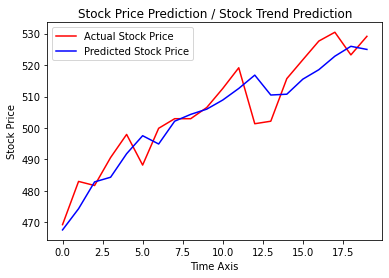

In [47]:
plt.plot(final_stock_pred['actual_stock_prices'], color = 'red', label = 'Actual Stock Price')
plt.plot(final_stock_pred['predicted_stock_prices'], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction / Stock Trend Prediction')
plt.xlabel('Time Axis')
plt.ylabel('Stock Price')
plt.legend()
plt.show()